# Simulate Transactions Matrix

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [9]:
item_file = "talent.pkl"
item_records, COLUMN_LABELS, READABLE_LABELS, ATTRIBUTES = pickle.load(open(item_file, "rb"))
df = pd.DataFrame(item_records)[ATTRIBUTES + COLUMN_LABELS].fillna(value=0)
df.head()

,id,name,price,reactions,stars,joined,categories,in_13_reasons_why,in_90_day_fiance,in_actors,...,in_ufc,in_vanderpump_rules,in_venture_capitalists,in_viners,in_vlog_squad,in_voice_actors,in_winter_sports,in_writers,in_younow,in_youtubers
0,perezhilton,Perez Hilton,27.0,924,5.0,April 2018,"[Reality TV, Commentators, Featured]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,andydick,Andy Dick,99.0,340,4.9,October 2018,"[Reality TV, Comedians, Featured, Actors]",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tjlavin,TJ Lavin,80.0,291,5.0,February 2018,"[Reality TV, Riders, Featured, Extreme Sports,...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,carsonkressley,Carson Kressley,59.0,290,5.0,October 2018,"[Reality TV, Bravo, Stylists, Featured, Actors...",0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,riffraff,RiFF RAFF,75.0,402,4.7,December 2017,"[Rappers, Featured, Musicians]",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
COLUMN_TO_READABLE = {}
READABLE_TO_COLUMN = {}
for column, readable in zip(COLUMN_LABELS, READABLE_LABELS):
    COLUMN_TO_READABLE[column] = readable
    READABLE_TO_COLUMN[readable] = column

## Properties of a Good Transaction Matrix

- **Sparsity:** The number of actual transactions is far smaller than the number of possible transactions.
- **Diversity:** The set of items purchased by a user has some variety.
- **Power Law:** The frequency of items appears to follow a long-tailed distribution, i.e., a small number of items accounts for a large amount of transactions and most items are purchased infrequently.

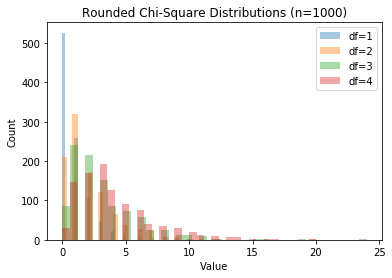

In [11]:
np.random.seed(0)
n_samples = 1000
for d in range(1, 5):
    vals = np.round(np.random.chisquare(df=d, size=n_samples)).astype(int)
    sns.distplot(vals, kde=False, label="df={}".format(d))
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Rounded Chi-Square Distributions (n={})".format(n_samples))
plt.legend()
plt.show()

In [13]:
category_map = {}
for category in COLUMN_LABELS:
    talent = df.query("{} == 1".format(category))["id"].values
    reactions = df.query("{} == 1".format(category))["reactions"].values
    freqs = reactions / np.sum(reactions)
    category_map[category] = {
        "talent": talent,
        "freqs": freqs
    }
all_talent = df["id"].values
all_reactions = df["reactions"].values
all_freqs = all_reactions / np.sum(all_reactions)
all_categories = df["categories"].values
talent_map = {}
for talent_id, category_list in zip(all_talent, all_categories):
    talent_map[talent_id] = [READABLE_TO_COLUMN[cat] for cat in category_list]

In [14]:
def simulate_transactions(n, degs=3, min_m=0, seed=0):
    np.random.seed(seed)
    added_transacs = np.round(np.random.chisquare(df=degs, size=n)).astype(int) + min_m
    res = []
    for i, m in enumerate(added_transacs):
        first_id = np.random.choice(all_talent, p=all_freqs)
        cat_set = set(talent_map[first_id])
        talent_set = set([first_id])
        for j in range(m):
            cat = np.random.choice(np.array(list(cat_set)))
            entry = category_map[cat]
            next_id = np.random.choice(entry["talent"], p=entry["freqs"])
            if next_id not in talent_set:
                talent_set.add(next_id)
                # Want to balance between diverse and similar categories
                if len(talent_set) < 1:
                    cat_set.update(talent_map[next_id])
        while len(talent_set) < min_m:
            rand_id = np.random.choice(all_talent, p=all_freqs)
            if rand_id not in talent_set:
                talent_set.add(rand_id)
        res.append({
            "transactions": talent_set,
            "categories": cat_set
        })
    return res

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

N = 5000
res = simulate_transactions(n=N, degs=3, min_m=6, seed=42)
trans_df = pd.DataFrame(res)
trans_df.head()

,categories,transactions
0,"{in_featured, in_spotlight, in_singer_songwriter}","{codyko, riffraff, chrisbharrison, ramona56, a..."
1,"{in_animals, in_lifestyle}","{owenthegriff, lala, elizabethsaint, joelfreem..."
2,"{in_bravo, in_below_deck, in_reality_tv}","{josiahbelowdeck, gizellebryant, colin_macyoto..."
3,"{in_actors, in_featured, in_reality_tv, in_com...","{kateflannery, codyko, riffraff, catherinesuth..."
4,"{in_musicians, in_singer_songwriter}","{rexsmith, lancebass, kevghost, dannyworsnop, ..."


In [9]:
mlb = MultiLabelBinarizer(classes=all_talent)
mlb.fit(trans_df["transactions"])
vecs = mlb.transform(trans_df["transactions"])
mat = pd.DataFrame(vecs)
pd.DataFrame(vecs, columns=mlb.classes_).head()

,perezhilton,andydick,tjlavin,carsonkressley,riffraff,chumlee,gilbertgottfried,icet,benhiggy,laturtle,...,chrisjaialex,voman,el_peego,thisannaisbananas,zachharper,johnoberg,zacpullam,kansasbowling,mattcirulnick,itsscaleb__
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


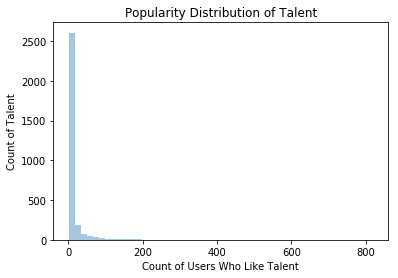

In [10]:
pop_dist = list(filter(lambda v: v > 0, mat.sum(axis=0).values))
sns.distplot(pop_dist, kde=False)
plt.xlabel("Count of Users Who Like Talent")
plt.ylabel("Count of Talent")
plt.title("Popularity Distribution of Talent")
plt.show()

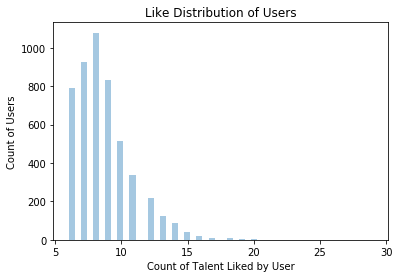

In [11]:
sns.distplot(mat.sum(axis=1).values, kde=False)
plt.xlabel("Count of Talent Liked by User")
plt.ylabel("Count of Users")
plt.title("Like Distribution of Users")
plt.show()

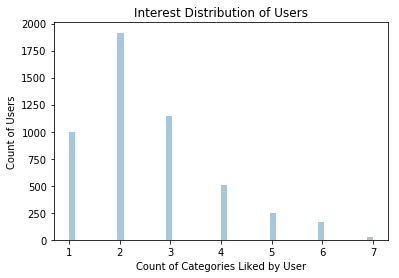

In [12]:
cat_lens = trans_df["categories"].apply(lambda s: len(s)).values
sns.distplot(cat_lens, kde=False)
plt.xlabel("Count of Categories Liked by User")
plt.ylabel("Count of Users")
plt.title("Interest Distribution of Users")
plt.show()

In [13]:
mat.head()

,0,1,2,3,4,5,6,7,8,9,...,5382,5383,5384,5385,5386,5387,5388,5389,5390,5391
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
ITEM_NAMES = mlb.classes_
ITEM_NAMES

array(['perezhilton', 'andydick', 'tjlavin', ..., 'kansasbowling',
       'mattcirulnick', 'itsscaleb__'], dtype=object)

In [18]:
from scipy.sparse import csr_matrix
import pickle

like_mat = csr_matrix(mat.values)
like_file = "likes.pkl"
pickle.dump(like_mat, open(like_file, "wb"))
print("Wrote {} records to {}.".format(len(mat), like_file))

Wrote 5000 records to likes.pkl.
